# Visual Question Answering and Image Captioning using BLIP and OpenVINO

Humans perceive the world through vision and language. A longtime goal of AI is to build intelligent agents that can understand the world through vision and language inputs to communicate with humans through natural language. In order to achieve this goal, vision-language pre-training has emerged as an effective approach, where deep neural network models are pre-trained on large scale image-text datasets to improve performance on downstream vision-language tasks, such as image-text retrieval, image captioning, and visual question answering.

[BLIP](https://github.com/salesforce/BLIP) is a language-image pre-training framework for unified vision-language understanding and generation. BLIP achieves state-of-the-art results on a wide range of vision-language tasks. This tutorial demonstrates how to use BLIP for visual question answering and image captioning.

The tutorial consists of the following parts:

1. Instantiate a BLIP model.
2. Convert the BLIP model to OpenVINO IR.
3. Run visual question answering and image captioning with OpenVINO.


#### Table of contents:
- [Background](#Background)
    - [Image Captioning](#Image-Captioning)
    - [Visual Question Answering](#Visual-Question-Answering)
- [Instantiate Model](#Instantiate-Model)
- [Convert Models to OpenVINO IR](#Convert-Models-to-OpenVINO-IR)
    - [Vision Model](#Vision-Model)
    - [Text Encoder](#Text-Encoder)
    - [Text Decoder](#Text-Decoder)
- [Run OpenVINO Model](#Run-OpenVINO-Model)
    - [Prepare Inference Pipeline](#Prepare-Inference-Pipeline)
    - [Select inference device](#Select-inference-device)
    - [Image Captioning](#Image-Captioning)
    - [Question Answering](#Question-Answering)
- [Interactive demo](#Interactive-demo)
- [Next steps](#Next-steps)


## Background
[back to top ⬆️](#Table-of-contents:)

Visual language processing is a branch of artificial intelligence that focuses on creating algorithms designed to enable computers to more accurately understand images and their content.

Popular tasks include:

* **Text to Image Retrieval** - a semantic task that aims to find the most relevant image for a given text description.
* **Image Captioning** - a semantic task that aims to provide a text description for image content.
* **Visual Question Answering** - a semantic task that aims to answer questions based on image content.

As shown in the diagram below, these three tasks differ in the input provided to the AI system. For text-to-image retrieval, you have a predefined gallery of images for search and a user-requested text description (query). Image captioning can be represented as a particular case of visual question answering, where you have a predefined question "What is in the picture?" and various images provided by a user. For visual question answering, both the text-based question and image context are variables requested by a user.

![](https://user-images.githubusercontent.com/29454499/221755717-a5b51b7e-523c-461f-b30c-4edbfaf9a134.png)

This notebook does not focus on Text to Image retrieval. Instead, it considers Image Captioning and Visual Question Answering.

### Image Captioning
[back to top ⬆️](#Table-of-contents:)

Image Captioning is the task of describing the content of an image in words. This task lies at the intersection of computer vision and natural language processing. Most image captioning systems use an encoder-decoder framework, where an input image is encoded into an intermediate representation of the information in the image, and then decoded into a descriptive text sequence.

![](https://user-images.githubusercontent.com/29454499/221640847-1868117c-aac0-4806-99a4-34f218e98bb8.png)

### Visual Question Answering
[back to top ⬆️](#Table-of-contents:)

Visual Question Answering (VQA) is the task of answering text-based questions about image content.

![](https://user-images.githubusercontent.com/29454499/221641984-3c6d8b2f-dd0d-4302-a4d8-0f8564fca772.png)

For a better understanding of how VQA works, let us consider a traditional NLP task like Question Answering, which aims to retrieve the answer to a question from a given text input. Typically, a question answering pipeline consists of three steps:

![](https://user-images.githubusercontent.com/29454499/221760881-378f1ea8-eadc-4610-aff0-69ecabf62fff.png)

1. Question analysis - analysis of provided question in natural language form to understand the object in the question and additional context. For example, if you have a question like "How many bridges in Paris?", question words *"how many"* gives a hint that the answer is more likely to be a number, *"bridges"* is the target object of the question and *" in Paris"* serves as additional context for the search.
2. Build query for search - use analyzed results to formalize query for finding the most relevant information.
3. Perform a search in the knowledge base - send the query to a knowledge base, typically provided text documents or databases serve as a source of knowledge.

![](https://user-images.githubusercontent.com/29454499/222094861-3cafdf9f-d700-4741-b6c5-fb09c1a4da9a.png)

The difference between text-based question answering and visual question answering is that an image is used as context and the knowledge base.

![](https://user-images.githubusercontent.com/29454499/222095118-3d5826e4-2662-4d1c-abf2-a515f23d6d6a.png)

Answering arbitrary questions about images is a complex problem because it requires involving a lot of computer vision sub-tasks. In the table below, you can find an example of questions and the required computer vision skills to find answers.

| Computer vision task                   | Question examples                                       |
|----------------------------------------| ------------------------------------------------------- |
| Object recognition                     | What is shown in the picture? What is it?               |
| Object detection                       | Is there any object (dog, man, book) in the image? Where is … located? |
| Object and image attribute recognition | What color is an umbrella? Does this man wear glasses? Is there color in the image? |
| Scene recognition                      | Is it rainy? What celebration is pictured? |
| Object counting                        | How many players are there on the football field? How many steps are there on the stairs? |
| Activity recognition                   | Is the baby crying? What is the woman cooking? What are they doing?                       |
| Spatial relationships among objects    | What is located between the sofa and the armchair? What is in the bottom left corner? |
| Commonsense reasoning                  | Does she have 100% vision? Does this person have children? |
| Knowledge-based reasoning              | Is it a vegetarian pizza? |
| Text recognition                       | What is the title of the book? What is shown on the screen? |


There are a lot of applications for visual question answering:

* Aid Visually Impaired Persons: VQA models can be used to reduce barriers for visually impaired people by helping them get information about images from the web and the real world.
* Education: VQA models can be used to improve visitor experiences at museums by enabling observers to directly ask questions they are interested in or to bring more interactivity to schoolbooks for children interested in acquiring specific knowledge.
* E-commerce: VQA models can retrieve information about products using photos from online stores.
* Independent expert assessment: VQA models can be provide objective assessments in sports competitions, medical diagnosis, and forensic examination.

## Instantiate Model
[back to top ⬆️](#Table-of-contents:)

The BLIP model was proposed in the [BLIP: Bootstrapping Language-Image Pre-training for Unified Vision-Language Understanding and Generation](https://arxiv.org/abs/2201.12086) paper.

![blip.gif](https://github.com/salesforce/BLIP/raw/main/BLIP.gif)

To pre-train a unified vision-language model with both understanding and generation capabilities, BLIP introduces a multimodal mixture of an encoder-decoder and a multi-task model which can operate in one of the three modes:

* **Unimodal encoders**, which separately encode images and text. The image encoder is a vision transformer. The text encoder is the same as BERT.
* **Image-grounded text encoder**, which injects visual information by inserting a cross-attention layer between the self-attention layer and the feed-forward network for each transformer block of the text encoder.
* **Image-grounded text decoder**, which replaces the bi-directional self-attention layers in the text encoder with causal self-attention layers.

More details about the model can be found in the [research paper](https://arxiv.org/abs/2201.12086), [Salesforce blog](https://blog.salesforceairesearch.com/blip-bootstrapping-language-image-pretraining/), [GitHub repo](https://github.com/salesforce/BLIP) and [Hugging Face model documentation](https://huggingface.co/docs/transformers/model_doc/blip).

In this tutorial, you will use the [`blip-vqa-base`](https://huggingface.co/Salesforce/blip-vqa-base) model available for download from [Hugging Face](https://huggingface.co/). The same actions are also applicable to other similar models from the BLIP family. Although this model class is designed to perform question answering, its components can also be reused for image captioning.

To start working with the model, you need to instantiate the `BlipForQuestionAnswering` class, using `from_pretrained` method. `BlipProcessor` is a helper class for preparing input data for both text and vision modalities and postprocessing of generation results.

In [ ]:
%pip install -q --extra-index-url https://download.pytorch.org/whl/cpu torch torchvision "transformers>=4.26.0" gradio "openvino>=2023.1.0" matplotlib


In [ ]:
from google.colab import files

# Upload a file
uploaded = files.upload()

# Access the uploaded file
for notebook_utils, content in uploaded.items():
    with open(notebook_utils, 'wb') as f:
        f.write(content)

# Now you can use the uploaded files in your code


Saving notebook_utils.py to notebook_utils (2).py


In [ ]:
import sys
import time
from PIL import Image
from transformers import BlipProcessor, BlipForQuestionAnswering

sys.path.append("../utils")
from notebook_utils import download_file

# get model and processor
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")

# setup test input: download and read image, prepare question
img_url = 'https://media.gucci.com/content/DiaryArticleSingle_Standard_1536x2150/1659707105/DiaryArticleSingle_hidden-horsebit-02-new_001_Default.jpg'
download_file(img_url, "demo.jpg")
raw_image = Image.open("demo.jpg").convert('RGB')
question = "can you describe the picture?"
# preprocess input data
inputs = processor(raw_image, question, return_tensors="pt")

start = time.perf_counter()
# perform generation
out = model.generate(**inputs)
end = time.perf_counter() - start

# postprocess result
answer = processor.decode(out[0], skip_special_tokens=True)

demo.jpg:   0%|          | 0.00/582k [00:00<?, ?B/s]

In [ ]:
print(f"Processing time: {end:.4f} s")

Processing time: 2.8709 s


In [ ]:
from google.colab import files

# Upload a file
uploaded = files.upload()

# Access the uploaded file
for utils, content in uploaded.items():
    with open(utils, 'wb') as f:
        f.write(content)

# Now you can use the uploaded files in your code


Saving utils.py to utils (4).py


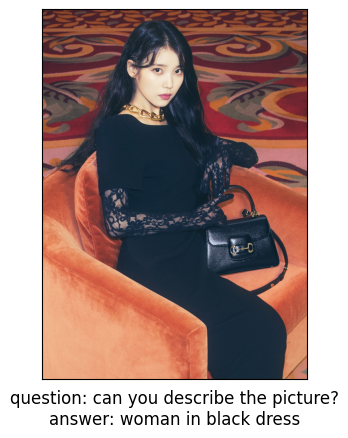

In [ ]:
from utils import visualize_results

fig = visualize_results(raw_image, answer, question)

## Convert Models to OpenVINO IR
[back to top ⬆️](#Table-of-contents:)

Starting from OpenVINO 2023.0 release, OpenVINO supports direct PyTorch models conversion to OpenVINO Intermediate Representation (IR) format to take the advantage of advanced OpenVINO optimization tools and features. You need to provide a model object, input data for model tracing to OpenVINO Model Conversion API. `ov.convert_model` function convert PyTorch model instance to `ov.Model` object that can be used for compilation on device or saved on disk using `ov.save_model` in compressed to FP16 format.

The model consists of three parts:

* vision_model - an encoder for image representation.
* text_encoder - an encoder for input query, used for question answering and text-to-image retrieval only.
* text_decoder - a decoder for output answer.

To be able to perform multiple tasks, using the same model components, you should convert each part independently.

### Vision Model
[back to top ⬆️](#Table-of-contents:)

The vision model accepts float input tensors with the [1,3,384,384] shape, containing RGB image pixel values normalized in the [0,1] range.

In [ ]:
import torch
from pathlib import Path
import openvino as ov

VISION_MODEL_OV = Path("blip_vision_model.xml")
vision_model = model.vision_model
vision_model.eval()

# check that model works and save it outputs for reusage as text encoder input
with torch.no_grad():
    vision_outputs = vision_model(inputs["pixel_values"])

# if openvino model does not exist, convert it to IR
if not VISION_MODEL_OV.exists():

    # export pytorch model to ov.Model
    with torch.no_grad():
        ov_vision_model = ov.convert_model(vision_model, example_input=inputs["pixel_values"])
    # save model on disk for next usages
    ov.save_model(ov_vision_model, VISION_MODEL_OV)
    print(f"Vision model successfuly converted and saved to {VISION_MODEL_OV}")
else:
    print(f"Vision model will be loaded from {VISION_MODEL_OV}")

Vision model will be loaded from blip_vision_model.xml


### Text Encoder
[back to top ⬆️](#Table-of-contents:)

The text encoder is used by visual question answering tasks to build a question embedding representation. It takes `input_ids` with a tokenized question and output image embeddings obtained from the vision model and attention masks for them.

In [ ]:
TEXT_ENCODER_OV = Path("blip_text_encoder.xml")


text_encoder = model.text_encoder
text_encoder.eval()

# if openvino model does not exist, convert it to IR
if not TEXT_ENCODER_OV.exists():
    # prepare example inputs
    image_embeds = vision_outputs[0]
    image_attention_mask = torch.ones(image_embeds.size()[:-1], dtype=torch.long)
    input_dict = {"input_ids": inputs["input_ids"], "attention_mask": inputs["attention_mask"], "encoder_hidden_states": image_embeds, "encoder_attention_mask": image_attention_mask}
    # export PyTorch model
    with torch.no_grad():
        ov_text_encoder = ov.convert_model(text_encoder, example_input=input_dict)
    # save model on disk for next usages
    ov.save_model(ov_text_encoder, TEXT_ENCODER_OV)
    print(f"Text encoder successfuly converted and saved to {TEXT_ENCODER_OV}")
else:
    print(f"Text encoder will be loaded from {TEXT_ENCODER_OV}")

Text encoder will be loaded from blip_text_encoder.xml


### Text Decoder
[back to top ⬆️](#Table-of-contents:)

The text decoder is responsible for generating the sequence of tokens to represent model output (answer to question or caption), using an image (and question, if required) representation. The generation approach is based on the assumption that the probability distribution of a word sequence can be decomposed into the product of conditional next word distributions. In other words, model predicts the next token in the loop guided by previously generated tokens until the stop-condition will be not reached (generated sequence of maximum length or end of string token obtained). The way the next token will be selected over predicted probabilities is driven by the selected decoding methodology. You can find more information about the most popular decoding methods in this [blog](https://huggingface.co/blog/how-to-generate). The entry point for the generation process for models from the Hugging Face Transformers library is the `generate` method. You can find more information about its parameters and configuration in the [documentation](https://huggingface.co/docs/transformers/v4.26.1/en/main_classes/text_generation#transformers.GenerationMixin.generate). To preserve flexibility in the selection decoding methodology, you will convert only model inference for one step.

To optimize the generation process and use memory more efficiently, the `use_cache=True` option is enabled. Since the output side is auto-regressive, an output token hidden state remains the same once computed for every further generation step. Therefore, recomputing it every time you want to generate a new token seems wasteful. With the cache, the model saves the hidden state once it has been computed. The model only computes the one for the most recently generated output token at each time step, re-using the saved ones for hidden tokens. This reduces the generation complexity from O(n^3) to O(n^2) for a transformer model. More details about how it works can be found in this [article](https://scale.com/blog/pytorch-improvements#Text%20Translation). With this option, the model gets the previous step's hidden states as input and additionally provides hidden states for the current step as output. Initially, you have no previous step hidden states, so the first step does not require you to provide them, but we should initialize them by default values.
In PyTorch, past hidden state outputs are represented as a list of pairs (hidden state for key, hidden state for value] for each transformer layer in the model. OpenVINO model does not support nested outputs, they will be flattened.

Similar to `text_encoder`, `text_decoder` can work with input sequences of different lengths and requires preserving dynamic input shapes.

In [ ]:
text_decoder = model.text_decoder
text_decoder.eval()

TEXT_DECODER_OV = Path("blip_text_decoder_with_past.xml")

# prepare example inputs
input_ids = torch.tensor([[30522]])  # begin of sequence token id
attention_mask = torch.tensor([[1]])  # attention mask for input_ids
encoder_hidden_states = torch.rand((1, 10, 768))  # encoder last hidden state from text_encoder
encoder_attention_mask = torch.ones((1, 10), dtype=torch.long)  # attention mask for encoder hidden states

input_dict = {"input_ids": input_ids, "attention_mask": attention_mask, "encoder_hidden_states": encoder_hidden_states, "encoder_attention_mask": encoder_attention_mask}
text_decoder_outs = text_decoder(**input_dict)
# extend input dictionary with hidden states from previous step
input_dict["past_key_values"] = text_decoder_outs["past_key_values"]

text_decoder.config.torchscript = True
if not TEXT_DECODER_OV.exists():
    # export PyTorch model
    with torch.no_grad():
        ov_text_decoder = ov.convert_model(text_decoder, example_input=input_dict)
    # save model on disk for next usages
    ov.save_model(ov_text_decoder, TEXT_DECODER_OV)
    print(f"Text decoder successfuly converted and saved to {TEXT_DECODER_OV}")
else:
    print(f"Text decoder will be loaded from {TEXT_DECODER_OV}")

Text decoder will be loaded from blip_text_decoder_with_past.xml


## Run OpenVINO Model
[back to top ⬆️](#Table-of-contents:)

### Prepare Inference Pipeline
[back to top ⬆️](#Table-of-contents:)

As discussed before, the model consists of several blocks which can be reused for building pipelines for different tasks. In the diagram below, you can see how image captioning works:

![](https://user-images.githubusercontent.com/29454499/221865836-a56da06e-196d-449c-a5dc-4136da6ab5d5.png)


The visual model accepts the image preprocessed by `BlipProcessor` as input and produces image embeddings, which are directly passed to the text decoder for generation caption tokens. When generation is finished, output sequence of tokens is provided to `BlipProcessor` for decoding to text using a tokenizer.

The pipeline for question answering looks similar, but with additional question processing. In this case, image embeddings and question tokenized by `BlipProcessor` are provided to the text encoder and then multimodal question embedding is passed to the text decoder for performing generation of answers.

![](https://user-images.githubusercontent.com/29454499/221868167-d0081add-d9f3-4591-80e7-4753c88c1d0a.png)

The next step is implementing both pipelines using OpenVINO models.

In [ ]:
# create OpenVINO Core object instance
core = ov.Core()

### Select inference device
[back to top ⬆️](#Table-of-contents:)

select device from dropdown list for running inference using OpenVINO

In [ ]:
import ipywidgets as widgets

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

In [ ]:
# load models on device
ov_vision_model = core.compile_model(VISION_MODEL_OV, device.value)
ov_text_encoder = core.compile_model(TEXT_ENCODER_OV, device.value)
ov_text_decoder_with_past = core.compile_model(TEXT_DECODER_OV, device.value)

In [ ]:
from google.colab import files

# Upload a file
uploaded = files.upload()

# Access the uploaded file
for blip_model, content in uploaded.items():
    with open(blip_model, 'wb') as f:
        f.write(content)

# Now you can use the uploaded files in your code


Saving blip_model.py to blip_model (2).py


In [ ]:
from functools import partial
from blip_model import text_decoder_forward

text_decoder.forward = partial(text_decoder_forward, ov_text_decoder_with_past=ov_text_decoder_with_past)

The model helper class has two methods for generation: **generate_answer** - used for visual question answering, **generate_caption** - used for caption generation.
For initialization, model class accepts compiled OpenVINO models for the text encoder, vision model and text decoder, and also configuration for generation and initial token for decoder work.

In [ ]:
from blip_model import OVBlipModel

ov_model = OVBlipModel(model.config, model.decoder_start_token_id, ov_vision_model, ov_text_encoder, text_decoder)
out = ov_model.generate_answer(**inputs, max_length=20)

Now, the model is ready for generation.

### Image Captioning
[back to top ⬆️](#Table-of-contents:)


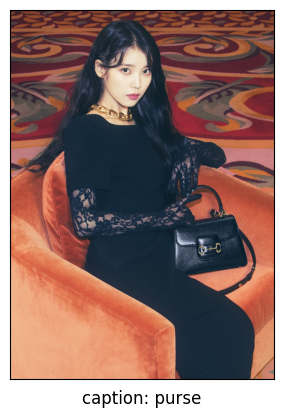

In [ ]:
out = ov_model.generate_caption(inputs["pixel_values"], max_length=20)
caption = processor.decode(out[0], skip_special_tokens=True)
fig = visualize_results(raw_image, caption)

### Question Answering
[back to top ⬆️](#Table-of-contents:)


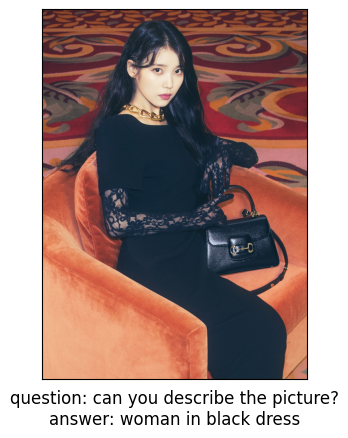

In [ ]:
start = time.perf_counter()
out = ov_model.generate_answer(**inputs, max_length=20)
end = time.perf_counter() - start
answer = processor.decode(out[0], skip_special_tokens=True)
fig = visualize_results(raw_image, answer, question)

In [ ]:
print(f"Processing time: {end:.4f}")

Processing time: 2.4951


## Interactive demo
[back to top ⬆️](#Table-of-contents:)


In [ ]:
# !pip install -U gradio
# !pip install typing-extensions

In [ ]:
# from google.colab import files

# # Upload a file
# uploaded = files.upload()

# # Access the uploaded file
# for typing_extensions, content in uploaded.items():
#     with open(typing_extensions, 'wb') as f:
#         f.write(content)

# # Now you can use the uploaded files in your code


In [ ]:
import gradio as gr


def generate_answer(img, question):
    if img is None:
        raise gr.Error("Please upload an image or choose one from the examples list")
    start = time.perf_counter()
    inputs = processor(img, question, return_tensors="pt")
    output = (
        ov_model.generate_answer(**inputs, max_length=20)
        if len(question)
        else ov_model.generate_caption(inputs["pixel_values"], max_length=20)
    )
    answer = processor.decode(output[0], skip_special_tokens=True)
    elapsed = time.perf_counter() - start
    html = f"<p>Processing time: {elapsed:.4f}</p>"
    return answer, html


demo = gr.Interface(
    generate_answer,
    [
        gr.Image(label="Image"),
        gr.Textbox(
            label="Question",
            info="If this field is empty, an image caption will be generated",
        ),
    ],
    [gr.Text(label="Answer"), gr.HTML()],
    examples=[["demo.jpg", ""], ["demo.jpg", question]],
    allow_flagging="never"
)
try:
    demo.launch(debug=True)
except Exception:
    demo.launch(share=True, debug=True)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/

ImportError: ignored

## Next steps
[back to top ⬆️](#Table-of-contents:)

Open the [233-blip-optimize](233-blip-optimize.ipynb) notebook to quantize vision and text encoder models with the Post-training Quantization API of NNCF
and compress weights of the text decoder. Then compare the converted and optimized OpenVINO models.